In [49]:
from classiq import*
import matplotlib.pyplot as plt
import numpy as np
import glob

## Objective

Our Intention is to design a quantum walk Operator for the case of line with 16 nodes.
Unlike discrete quantum walk in 4 nodes as done in classiq Bootcamp which are all connected here 0th node and 16 th node has no connection.We need to find an intuitive way to include the logic of this terminating region.
Before all this,let's figure what is actually Random Walk and Quantum Walk.


## Random Walk


It is a random process in which each step of walker is random where outcome of each step has equal probability.




For instance,if a walker starts the walk from initial position (say origin(0)),he can move one step higher(+1) or lower(-1) with equal probability,this is equivalent to tossing a fair coin such that for each Head or Tail walker moves forward or backward.


## Quantum Walk

Quantum Walk is analogous to random walk.Here instead of Walker position in a definite integer as in Classical random walk,it is in superposition of integer position eigenstates.To create a superposition state here we use a "coin operator" and to move the walker from current state to new state we use a "shift operator".
# Advantage
 Quantum walk provide an exponential and polynomial speedup over classical algorithm fo practical problems.
 One example for this is quantum walk may help to understand photosynthetic energy transfer which may enable us to understand how higher  efficiency of energy transfer attained in photosynthesis process and thereby utilising this knowledge increasing energy transfer efficiency of solar cells equivalent to efficiency in photosynthesis process.
 
 
 ref:http://www.intechopen.com/books/search-algorithms-and-applications/search-via-quantum-walk



# Problem

design the quantum walk operator for the case of a line with 16 nodes

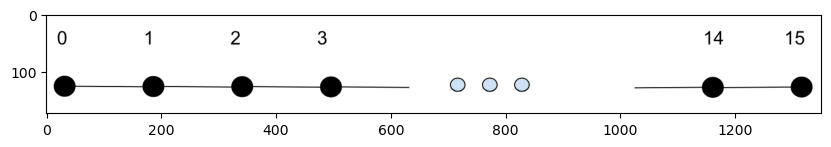

In [50]:
plt.figure(figsize=(10,10))
img0=plt.imread('Classiq_FinalAssignment_Fig1.png')
plt.imshow(img0)

Given below are the 2 equations we try to implement in the entire code C(coin operator) and S(shift operator)

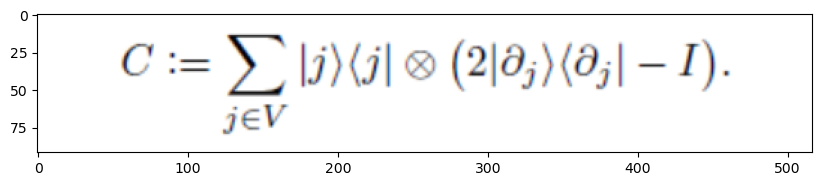

In [51]:
plt.figure(figsize=(10,10))
img01=plt.imread('C.png')
plt.imshow(img01)

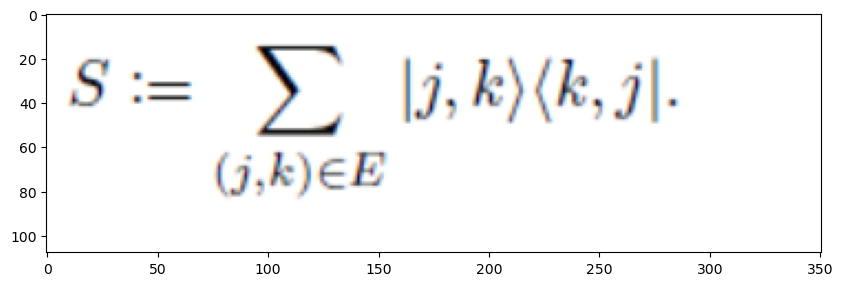

In [53]:
plt.figure(figsize=(10,10))
img02=plt.imread('S.png')
plt.imshow(img02)

Image Credits:Lecture Notes on Quantum Algorithms,Andrew M. Childs


Coin operator determine the probability of the walker whereas shift operator moves the walker from one state to another

In the code, we have to create 4 qubits for representing vertices so size is set as 4

In [54]:

size = 4
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


In [55]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


In [56]:

@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


Here functions such as "prepare_minus,diffuzer_oracle,and zero_diffuzer" is used to implement phase kickback 
just like in all search algorithms here.Morover it tries to implement a sub part of equation in C which is
shown below.

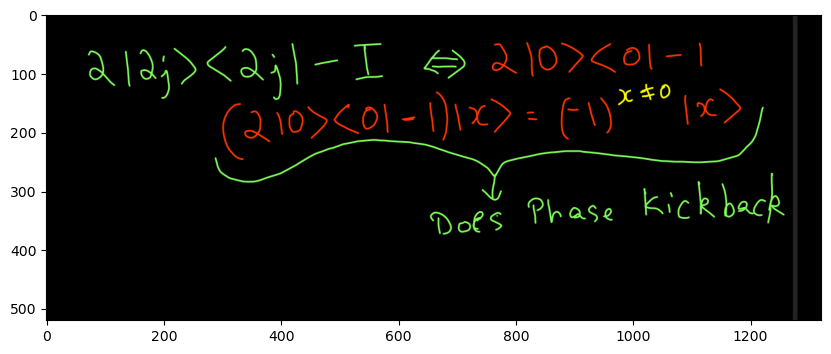

In [57]:
plt.figure(figsize=(10,10))
img0=plt.imread('phase kickback.png')
plt.imshow(img0)

In [58]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*16
    if i==0:
         prob[(i+1)%16]=1
    elif i==15:
        prob[(i-1)%16]=1
    else:
        prob[(i+1)% 16]=0.5
        prob[(i-1)% 16]=0.5
        
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

C_iteration function distributes equal probability for adjacent nodes as 0.5 except for 0th node and 15th node as they have connection to only one node.

In [59]:

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)


Here C_operator is applied to all vertices.

  From this part onwards we apply sections for shift operator equation starting with edge oracle,then a bitwise swap and including both in S_operator

In [60]:

@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
      res |=((vertices-adjacent_vertices)**2) ==1 

Edge_oracle checks whether two vertices are connected by edges.here difference of (vertices-adjacent_vertices)
must be +1 or -1 so that edge oracle exactly selects only adjacent vertices.

In [61]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

bitwise_swap is used to encode the subpart of equation as shown below.It also simulate walkers movement from one to the other
by swapping the bits.


for instance,|01> to |10> where |01> represents 1 and latter represents 2.Using bitwise swap we can simulate a walk from 1st node
to 2nd node

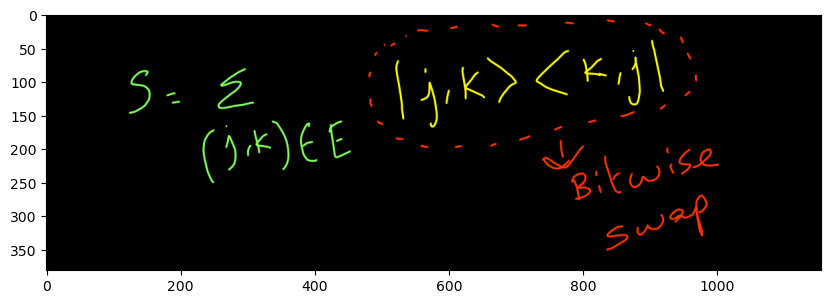

In [62]:
plt.figure(figsize=(10,10))
img1=plt.imread('bitwise swap.png')
plt.imshow(img1)

In [63]:

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


Creating a shift operator by including edge oracle and bitwise swap

In [64]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

Finally allocating qubits for adjacent vertices and vertices and applying hadamard transform to vertices to create
equal superposition and finally applying C and S operator to create quantum walk simulation.

In [65]:

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
write_qmod(qmod,'Quantum_walk on 15 nodes')

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

# Circuit Diagrams

Here is the full implementation of the quantum walk

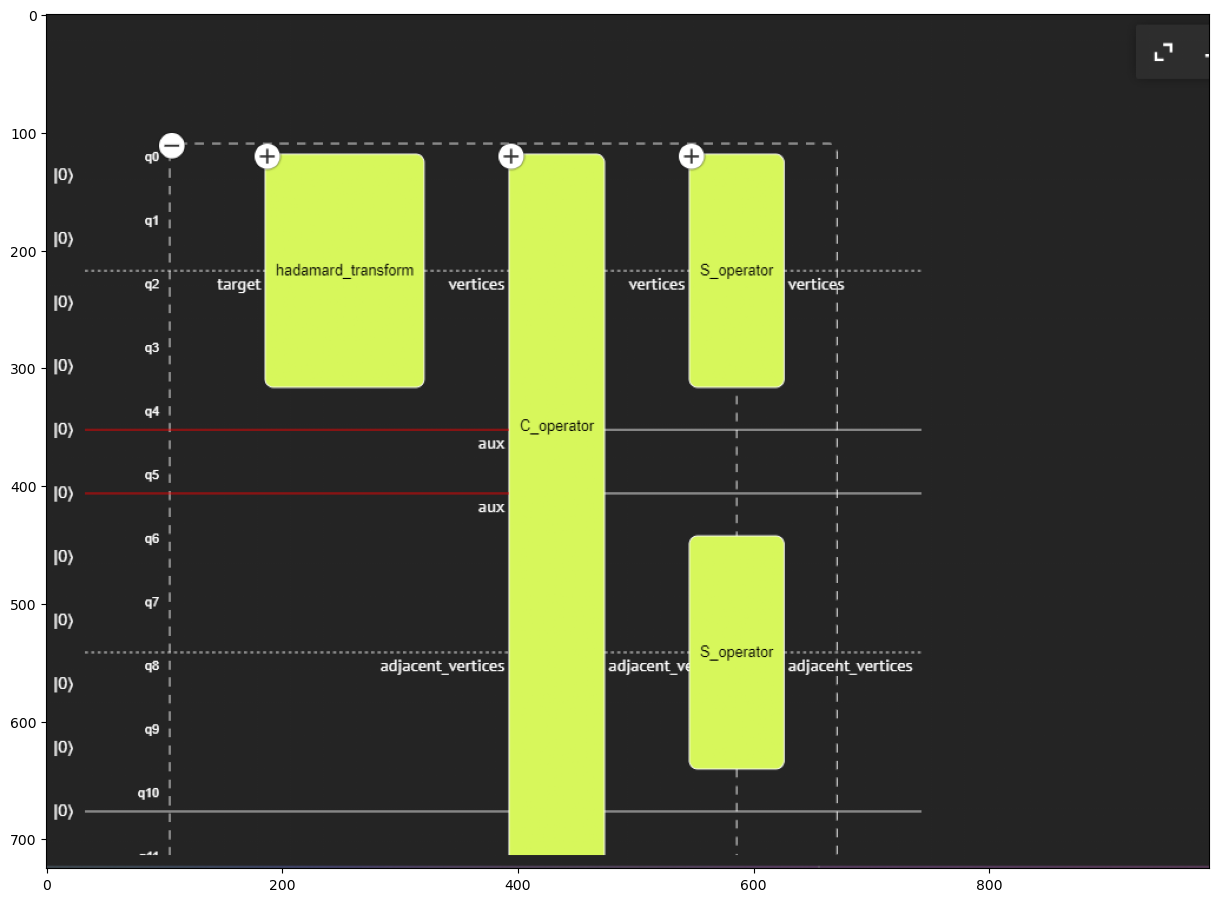

In [66]:
plt.figure(figsize=(15,15))
img4=plt.imread('full implementation.png')
plt.imshow(img4)

# C operator Ciruit Diagram

C operator is applied for 16 nodes,this is just a segment of C operator.Here state_prepation sets the probability for
walker to move to adjacent node as we seen in the output.Zero diffuser ensures to amplify the desired probability amplitudes using phas kickback

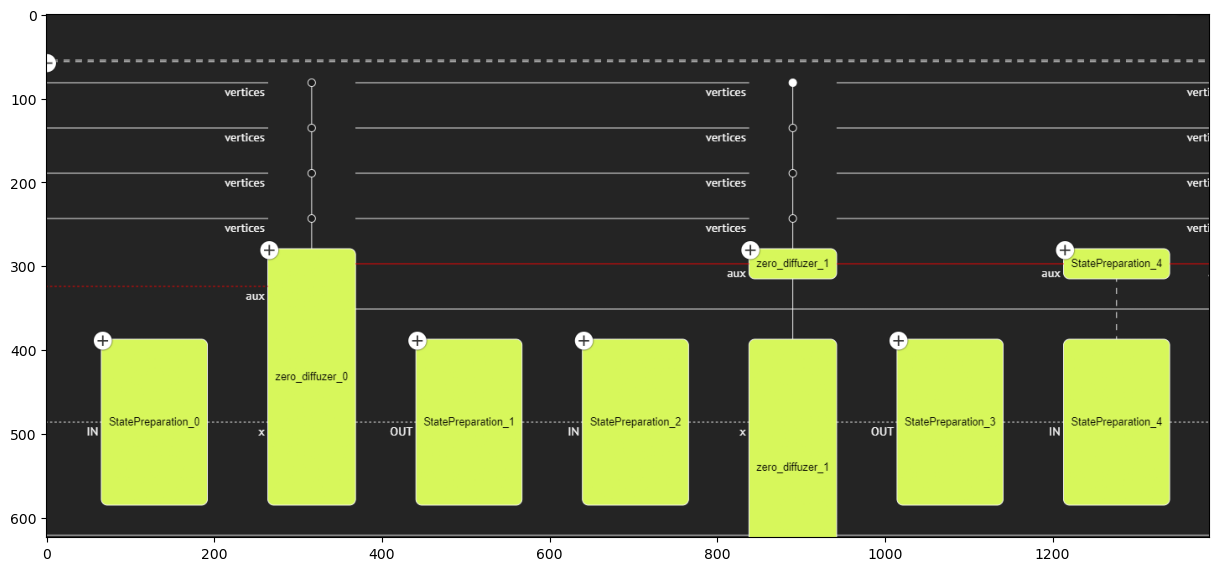

In [67]:
plt.figure(figsize=(15,15))
img5=plt.imread('C operator expansion.png')
plt.imshow(img5)

# Shift operator circuit diagram

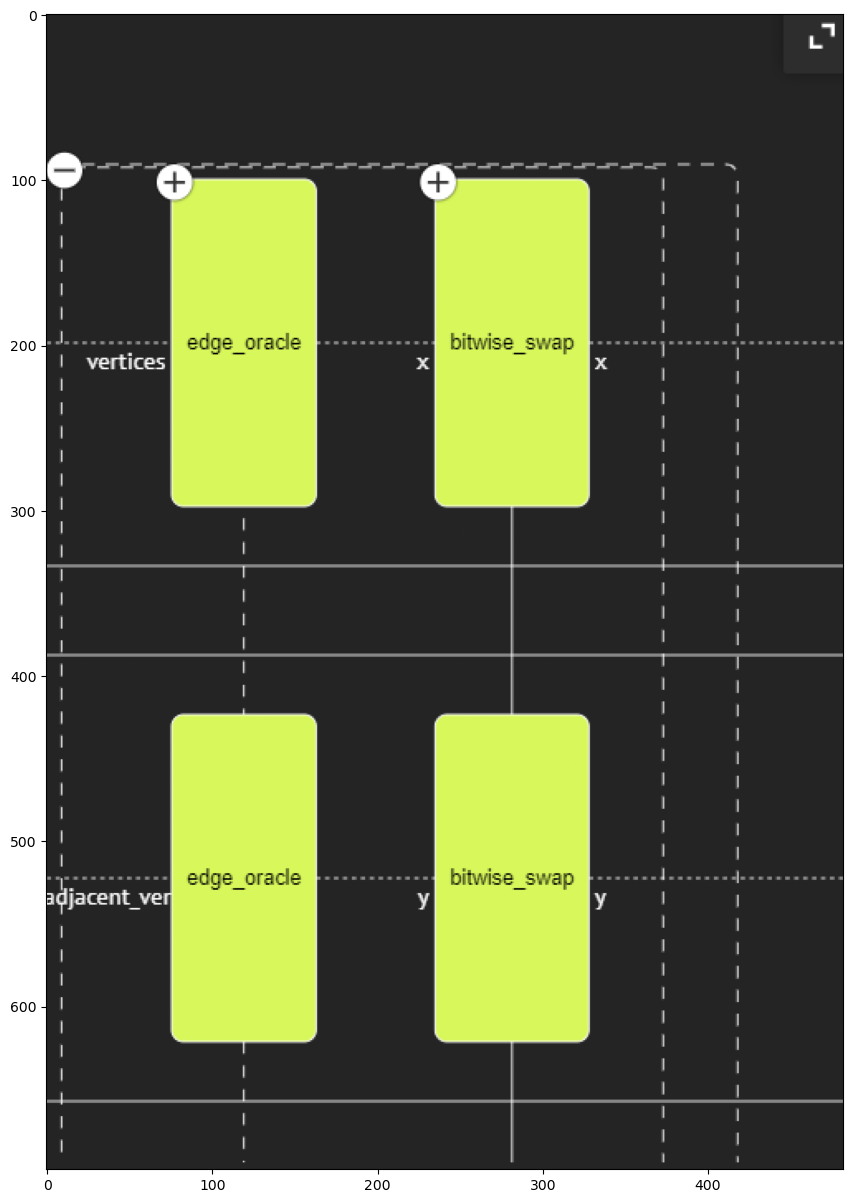

In [68]:
plt.figure(figsize=(15,15))
img5=plt.imread('S operation expansion.png')
plt.imshow(img5)

Here as we can see edge oracle checks whether vertices are connected,if they are qubit sets to 1 and bitwise swap only happens if vertices are connected so as to simulate quantum walk between adjacent vertices.